# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
# These libraries may be useful to you

# You also need a Python version => 3.9.0
import nltk
#nltk.download('brown')
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
#spacy.cli.download("en_core_web_sm")
import en_core_web_sm

from collections import Counter, defaultdict

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


nlp = en_core_web_sm.load()

C:\Users\jessh\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\jessh\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
# add any additional libaries you need here
#!pip install pyLDAvis==3.4.1 --user  
#!pip install spacy


In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot:xlabel='category'>

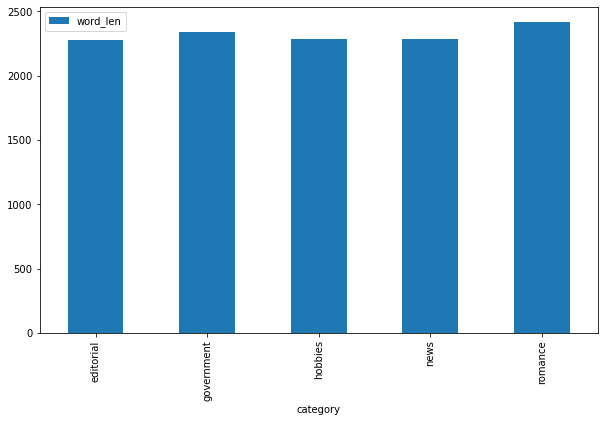

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [9]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: Both dataframes are ways to vectorize the text data we are using. The results are the document term matrices and it will give you the number of documents vs number of terms. In this case it is 166 documents to 4941 terms.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [10]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [11]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [12]:
# map from topic index to category
topic_to_category = {
    0: "editorial",
    1: "government",
    2: "news",
    3: "romance",
    4: "hobbies"
}

# classify all documents in the Brown corpus and get the predicted labels
df['predicted_category']  = ''

for i in range(W_text_matrix.shape[0]):
    predicted_topic_index = W_text_matrix[i].argmax()
    predicted_topic_category = topic_to_category[predicted_topic_index]
    df.at[i, 'predicted_category'] = predicted_topic_category

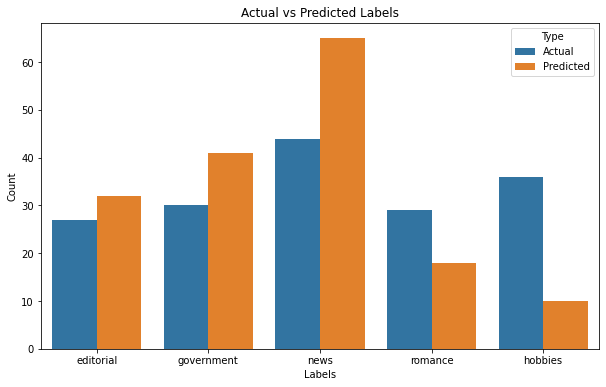

In [13]:
# create a bar plot of predicted vs actual labels
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', hue='Type', data=pd.DataFrame({'Label': df['category'].tolist() + df['predicted_category'].tolist(), 
                                                        'Type': ['Actual'] * len(df['category']) + ['Predicted'] * len(df['predicted_category'])}))
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Actual vs Predicted Labels')
plt.show()

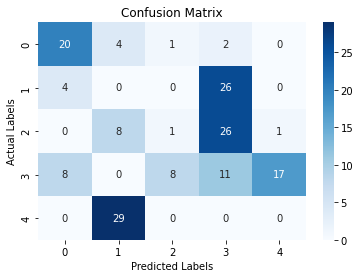

In [14]:
predicted_labels = df['predicted_category']
actual_labels = df['category']

# Create a confusion matrix heatmap
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

Q: How does your five-topic NMF model compare to the original Brown categories? 

The NMF model did a better job at classifying documents that are editorial, government, or news, but did not do very well at romance or documents containing hobbies. This is keeping in mind that:

* For editorial we have 27 articles.
* For government we have 30 articles.
* For hobbies we have 36 articles.
* For news we have 44 articles.
* For romance we have 29 articles.

The heatmap shows a more in depth view where government and news docs were often misclassified as romance. There is also the observation that hobbies were often misclassified as government articles.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [15]:
# Fit a TruncatedSVD model
num_topics = 5  # Number of topics
lsa_model = TruncatedSVD(n_components=num_topics)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_text_vectors)

In [16]:
lsa_df = df.drop(['predicted_category'], axis = 1)
# classify all documents in the Brown corpus and get the predicted labels
lsa_df['predicted_category']  = ''

for i in range(lsa_topic_matrix.shape[0]):
    predicted_topic_index = lsa_topic_matrix[i].argmax()
    predicted_topic_category = topic_to_category[predicted_topic_index]
    lsa_df.at[i, 'predicted_category'] = predicted_topic_category

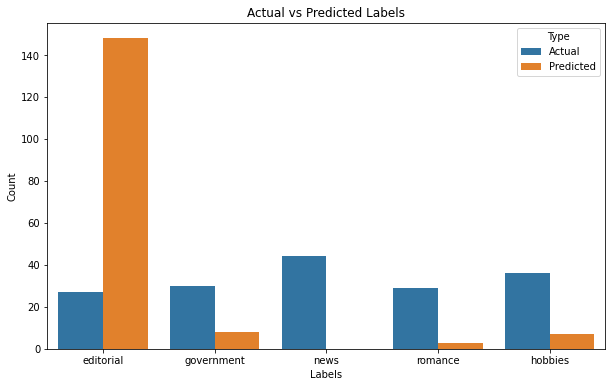

In [17]:
# create a bar plot of predicted vs actual labels
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', hue='Type', data=pd.DataFrame({'Label': lsa_df['category'].tolist() + lsa_df['predicted_category'].tolist(), 
                                                        'Type': ['Actual'] * len(lsa_df['category']) + ['Predicted'] * len(lsa_df['predicted_category'])}))
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Actual vs Predicted Labels')
plt.show()

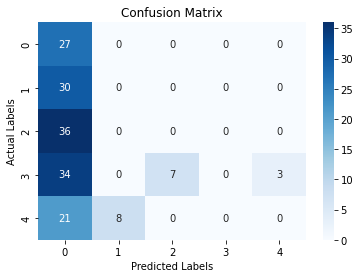

In [18]:
predicted_labels = lsa_df['predicted_category']
actual_labels = lsa_df['category']

# Create a confusion matrix heatmap
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model did pretty bad. It almost always just classifed the document as editorial. In comparison to the NMF model, the NMF model did a better job.

In [19]:
# call display_topics on your model
display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.90)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.16)
  mr (1.71)
  said (1.00)
  khrushchev (0.80)
  kennedy (0.79)

Topic 03
  mrs (31.09)
  club (6.95)
  game (6.48)
  jr (5.88)
  dallas (5.38)

Topic 04
  game (4.42)
  league (3.16)
  baseball (3.12)
  ball (2.95)
  team (2.83)


Q: What is your interpretation of the display topics output? 

A: For each topic, there are words with the associated weight to indicate how strong each word contributes to the topic.
* For topic 00, the words were all not highly weighted, but "said" was considered the highest.
* For topic 01, the word "said" contributed the most to this topic.
* For topic 02, the word "mrs" contributed the most to the topic.
* For topic 03, the word "mrs" contributed a significant amount to the topic.
* For topic 04, the word "game" contributed the most to the topic.

There were overlapping high contributing words for multipe categories, which could explain why the model was classifying in that manner.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [20]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topic_matrix = lda_text_model.fit_transform(count_text_vectors)

In [21]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


In [22]:
lda_df = df.drop(['predicted_category'], axis = 1)
# classify all documents in the Brown corpus and get the predicted labels
lda_df['predicted_category']  = ''

for i in range(lda_topic_matrix.shape[0]):
    predicted_topic_index = lda_topic_matrix[i].argmax()
    predicted_topic_category = topic_to_category[predicted_topic_index]
    lda_df.at[i, 'predicted_category'] = predicted_topic_category

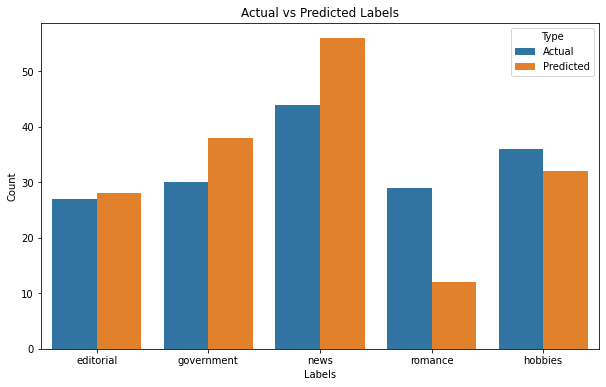

In [23]:
# create a bar plot of predicted vs actual labels
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', hue='Type', data=pd.DataFrame({'Label': lda_df['category'].tolist() + lda_df['predicted_category'].tolist(), 
                                                        'Type': ['Actual'] * len(lda_df['category']) + ['Predicted'] * len(lda_df['predicted_category'])}))
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Actual vs Predicted Labels')
plt.show()

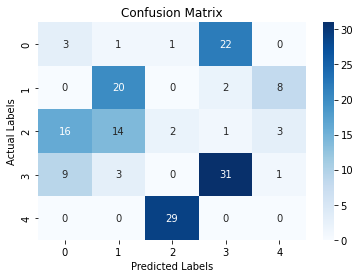

In [24]:
predicted_labels = lda_df['predicted_category']
actual_labels = lda_df['category']

# Create a confusion matrix heatmap
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

Q: What inference do you draw from the displayed topics for your LDA model? 

A: I would say that the model will have a hard time discerning documents for topic 02 and topic 04 as the word "said" is their top contending word. Otherwise, the classifier should do well in the other topics.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: It actually did pretty well in discerning topic 02 from topic 04. However, the LDA model often misclassified topic 00 as topic 03 and topic 04 as topic 02. 

In [25]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [26]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: If you select Topic 1, the distance between that and all other topics is pretty far. Topic 1's salient terms are listed on the right and the red portion of the bar graph is how often those words appeared in the topic across all documents. The same can be said for Topic 5. For Topics 2, 3, and 4, the topics are overlapping - meaning those topics are similar or similar words are used across those topics which makes it harder to seperate. For those topics, you can see in the salient terms graph that there are overlapping terms.
